# ArcelorMittal sorting hat

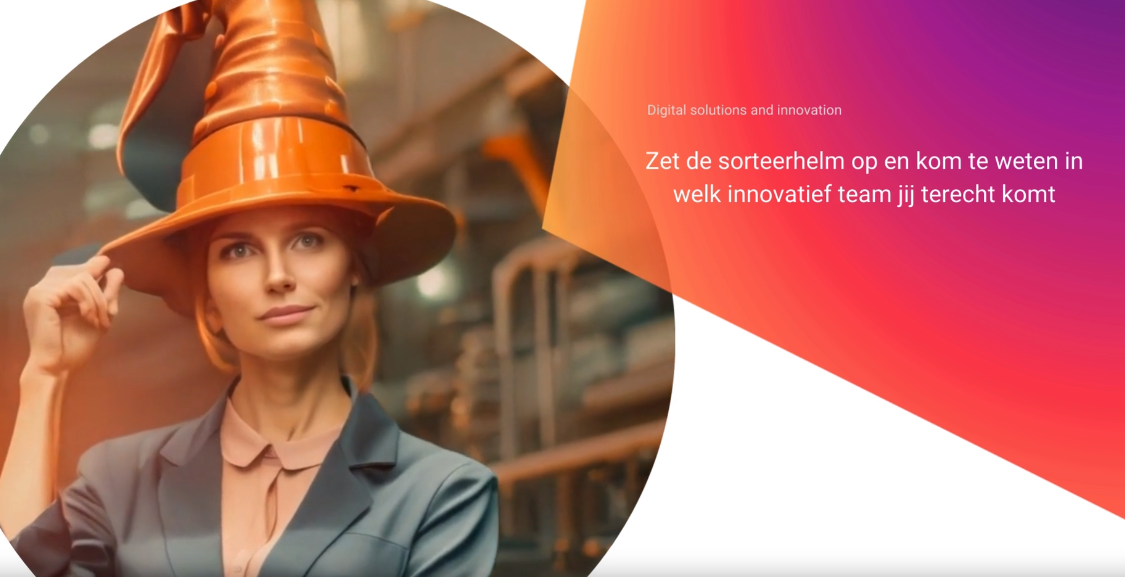

The sorting hat is a concept based on the Harry Potter sorting hat. The idea is that a person puts on a safety hardhat and that "magic" or in this case artificial intelligence makes a choice about the team that would fit the person.

ArcelorMittal Belgium reserves all rights both on code & intellectual property. This file, code or any derivates cannot be shared to other people without explicit approval of ArcelorMittal Belgium.

# Dependencies

When installing this locally, make sure to check your CUDA version and check the pytorch website what you need to install. eg `torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121`

In [ ]:
!pip install ultralytics ultralyticsplus decord screeninfo

# The code

The code. You may want to change the
`if __name__ == '__main__': `
statement at the bottom as this will only work when running this as a python file

# Parameters

- PRODUCTS_FOLDER: folder that contains videos that will randomly be shown with the detected person in overlay
- X_OFFSET: position from the left where to draw the overlay
- FRAMES_BUFFER: how many frames are used as a buffer to avoid flickering
...

# How it works

* The function ui_runner is the main loop
* The main loop must show an intro video, or a product video, depending on if a person wearing a hardhat is detected

For the **hardhat** detection, a **pre-trained** model is used. The models can be found on huggingface: https://huggingface.co/keremberke/yolov8n-hard-hat-detection (this is the "n" nano version). For the segmentation, the out of the box yolov8 segmentation model by ultralytics is used. All information on how to used the models can be found on their site.

Because we do not know the eventual framerate of the application, one of the challenges is to show the intro & product videos in real-time. This means that the right frame from the video must be shown at the right time.


# Challenges

* **Improve performance**. The overlay part & manipulation of the images in particular is one of the things that needs improvement. The inference speed of the models is not a great concern.
* **Improve reliability**. Specific lighting conditions, webcam used & distance to the camera heavily influence the detection rate.
* **Usability**.
 * When a product video is fully shown, it might be a good idea to show a message to take of the helmet.
 * Using helments of different colours could pick videos from different folders
 * Other things you can think of: show the person wearing an arcelormittal uniform, fingerprint the person, overall graphical improvement

In [4]:
import collections
from ultralyticsplus import YOLO
import cv2
import random
import os
import numpy as np
import math
from timeit import default_timer as timer
from PIL import Image, ImageTk, ImageFilter
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import time
from decord import VideoReader
from decord import cpu, gpu
from screeninfo import get_monitors

### Settings
USE_WEBCAM = False                      # Use webcam or video file
WINDOW_NAME_START = "Sorting hat"       # Window name of main window
PRODUCTS_FOLDER = "product_videos"      # Folder from with to select random videos
DEBUG = False                           # Show video cam window
X_OFFSET = 690                          # Offset of videocam on X-axis (deprecated)
DRAW_BOXES = False                      # Draw detection boxes - only use this for debug
FRAMES_BUFFER = 60                      # How many frames to use as a buffer. If in half of this, a hat is detected we assume someone has a hat on
DEVICE='cpu'                            # Device for detection. Use 'cpu' or 0
BLUR_MASK = True                        # Apply a gaussian blur on the mask for smoother edges
INTRO_VIDEO = "loop.mp4"                # Video to show when no hat is detected
COUNT_DOWN_VIDEO = "countdown.mp4"      # Intermediate scene to show when a hat is detected
SHOW_FPS = False                        # Show FPS on screen
### End of settings


# Singleton auxiliary classes
class SegmentationModel(object):
    _instance = None

    def __init__(self):
        raise RuntimeError('Call instance() instead')

    @classmethod
    def instance(cls):
        if cls._instance is None:
            print('Loading segmentation model')
            cls._instance = cls.__new__(cls)
            cls._model = YOLO('yolov8n-seg.pt')
            cls._model.overrides['conf'] = 0.2  # NMS confidence threshold
            cls._model.overrides['iou'] = 0.45  # NMS IoU threshold
            cls._model.overrides['agnostic_nms'] = False  # NMS class-agnostic
            cls._model.overrides['max_det'] = 5  # maximum number of detections per image
            cls._colors = [[random.randint(0, 255) for _ in range(3)] for _ in cls._model.names]
        return cls._instance

    def model(cls):
        return cls._model

    def class_names(cls):
        return cls._model.names

    def colors(cls):
        return cls._colors

class HardHatModel(object):
    _instance = None
    _queu_length = FRAMES_BUFFER
    _queue = collections.deque(maxlen=_queu_length)

    def __init__(self):
        raise RuntimeError('Call instance() instead')

    @classmethod
    def instance(cls):
        if cls._instance is None:
            print('Loading hardhat detection model')
            cls._instance = cls.__new__(cls)
            cls._model = YOLO('yolov8n-hardhat.pt')
            cls._model.overrides['conf'] = 0.2  # NMS confidence threshold
            cls._model.overrides['iou'] = 0.45  # NMS IoU threshold
            cls._model.overrides['agnostic_nms'] = False  # NMS class-agnostic
            cls._model.overrides['max_det'] = 5  # maximum number of detections per image
        return cls._instance

    def model(cls):
        return cls._model

    def register_detection(cls, bool):
        cls._queue.append(bool)

    def is_detected(cls):
        if (cls._queue.count(True) > int(cls._queu_length / 2)):
            return True
        else:
            return False

class Screen(object):
    _instance = None

    def __init__(self):
        raise RuntimeError('Call instance() instead')

    @classmethod
    def instance(cls):
        if cls._instance is None:
            print('Creating screen instance')
            cls._instance = cls.__new__(cls)
            cls.monitor = get_monitors()[0]
        return cls._instance

    def get_screen_res(self):
        return self.monitor.width, self.monitor.height

class SegmentBuffer(object):
    _instance = None
    _overlay = None
    _used_counter = 0

    def __init__(self):
        raise RuntimeError('Call instance() instead')

    @classmethod
    def instance(cls):
        if cls._instance is None:
            print('Creating segmentation buffer')
            cls._instance = cls.__new__(cls)
        return cls._instance

    def set(self, overlay:Image):
        self._overlay = overlay

    def get(self) -> Image:
        self._used_counter += 1
        if self._used_counter > 5:
            self._overlay = None
            self._used_counter = 0
        return self._overlay

class WebCam(object):
    _instance = None

    def __init__(self):
        raise RuntimeError('Call instance() instead')

    @classmethod
    def instance(cls):
        if cls._instance is None:
            print('Opening camera')
            cls._instance = cls.__new__(cls)
            if USE_WEBCAM:
                cls._cam = cv2.VideoCapture(0)
            else:
                cls._cam = cv2.VideoCapture("cam.mp4")
            cls._cam.set(3, 1024) #https://stackoverflow.com/questions/19448078/python-opencv-access-webcam-maximum-resolution
            cls._cam.set(4, 786)
        return cls._instance

    def cam(cls):
        return cls._cam

class HatWearingState(object):
    _instance = None
    _initial = None
    _state = False

    def __init__(self):
        raise RuntimeError('Call instance() instead')

    @classmethod
    def instance(cls):
        if cls._instance is None:
            cls._instance = cls.__new__(cls)
            print('Creating hat state singleton')
        return cls._instance

    def update(cls, bool):
        if  cls._initial is None or cls._state != bool:
            cls._initial = ""
            cls._state = bool
            return True, cls._state
        return False, cls._state
# End of singleton classes

def quit():
    cv2.destroyAllWindows()
    WebCam.instance().cam().release()
    exit()

def get_random_background():
    return random.choice(os.listdir(PRODUCTS_FOLDER))

def cv2_aspectratio_image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

# Function to get the video frame, horizontal flip and resize
def get_frame():
    ret, img= WebCam.instance().cam().read()
    img = cv2.flip(img, 1) #Horizontal Flip
    if not ret:
        print("Ignoring empty camera frame.")
        if not USE_WEBCAM:
            WebCam.instance().cam().set(cv2.CAP_PROP_POS_FRAMES,0) #Reset video to start to loop the video
        return None
    w, h = Screen.instance().get_screen_res()
    return cv2_aspectratio_image_resize(img, width=int(w/2.2)) #Resize to less than 50% of screen width

def extract_image_masks(img,masks,hat_boxes):
    tempimage = img
    allimage = img
    tempmasks = None
    allmasks = None
    for mask in masks:
        polygon_coords = mask
        mask = np.zeros_like(img[:, :, 0], dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(polygon_coords, dtype=np.int32)], color=255)

        segment_shape = False
        for box in hat_boxes:
            # bounding box
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values
            midpoint_x = int((x1 + x2) / 2)
            midpoint_y = int((y1 + y2) / 2)
            point = Point(midpoint_x, midpoint_y)
            polygon = Polygon(polygon_coords)
            segment_shape = polygon.contains(point)

        if segment_shape:
            if tempmasks is None:
                tempmasks = mask
            else:
                tempmasks = cv2.add(tempmasks, mask)
        if allmasks is None:
            allmasks = mask
        else:
            allmasks = cv2.add(allmasks, mask)
    tempimage = cv2.bitwise_and(tempimage, img, mask=tempmasks)
    allimage = cv2.bitwise_and(allimage, img, mask=allmasks)

    return tempimage, tempmasks, allimage, allmasks

def segment(frame, hat_boxes, segmentmasks):
    if segmentmasks is not None:
        if not hasattr(segmentmasks,"xy"):
            print("No attribute XY")

    img, segmentedmasks, all, allmasks = extract_image_masks(frame,segmentmasks.xy, hat_boxes)

    return img, segmentedmasks, all, allmasks

def get_smooth_overlay(mask, foreground):
        # Transform cv2 to PIL, because PIL is easier to work with
        foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
        PILImage = Image.fromarray(foreground)
        PILImage = PILImage.convert("RGBA")

        # Do the same with the mask but transform this image into Grayscale (L) because we want to use it as alpha mask
        PILMask = Image.fromarray(mask)
        PILMask = PILMask.convert("L")

        # Smoothen the mask
        if BLUR_MASK:
            #PILMask.filter(ImageFilter.GaussianBlur(3))
            PILMask.filter(ImageFilter.MedianFilter(size=3)) # This is faster and gives a good result

        # Apply the mask on the image
        PILImage.putalpha(PILMask)

        # Automatically crop to the non-empty (non-transparent) extents
        PILImage = PILImage.crop(PILImage.getbbox())

        # Transform again to cv2 image
        open_cv_image = np.array(PILImage)

        return open_cv_image

def overlay(backgroundimage, foreground, masks, x_offset, y_offset, fullsegment, fullmask):
    # We need to return a new frame, including overlay
    # First step: copy background image & transform it into a PIL Image (this implies we have to transform color)
    #background = backgroundimage.copy()
    rgb_background = cv2.cvtColor(backgroundimage, cv2.COLOR_BGR2RGB)
    pil_background = Image.fromarray(rgb_background)
    del rgb_background

    # Get the last known buffer, in case we do not have a clear detection
    buffer = SegmentBuffer.instance().get()

    # Calculate a few width & height values to resize, keeping aspect ratio
    h = pil_background.height
    w = pil_background.width
    max_crop_height = int(h*0.5)
    max_crop_width = int(w*0.5)

    if masks is not None:
        # Get a transparent, cropped image including only the segmented person
        pil_foreground = Image.fromarray(get_smooth_overlay(masks,foreground))

        # Apply some resizing to make sure the foreground has a certain height
        if pil_foreground.height > max_crop_height:
            pil_foreground.thumbnail((w,max_crop_height))
        else:
            width = pil_foreground.width
            resized_width = int(width * max_crop_height / pil_foreground.height)
            pil_foreground = pil_foreground.resize((resized_width,max_crop_height))
        pil_background.paste(pil_foreground, (int(w/2) - int(pil_foreground.width / 2), h - pil_foreground.height), pil_foreground)

        # Set this image as the last known foreground image for buffering purposes
        SegmentBuffer.instance().set(pil_foreground)
    elif buffer is not None:
        # If a person/hardhat combination was not found for a few seconds, show the last known image from the buffer
        # to avoid flickering
        pil_background.paste(buffer, (int(w/2) - int(buffer.width / 2), h - buffer.height), buffer)

    # Transform PIL to CV2 & transform RGB to BRG
    np_background = np.array(pil_background,dtype='uint8')
    del pil_background
    np_background = np_background[:, :, ::-1]

    return np_background

def hardhat_within_personbox(hardhatboxes, people_boxes) -> bool:
    for box in hardhatboxes:

        # class name
        cls = int(box.cls[0])

        # bounding box
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values
        midpoint_x = int((x1 + x2) / 2)
        midpoint_y = int((y1 + y2) / 2)
        for person in people_boxes:
            px1, py1, px2, py2 = person
            if (cls == 0 and midpoint_x > px1 and midpoint_x < px2 and midpoint_y > py1 and midpoint_y < py2):
                return True

        return False

def draw_hardhat_boxes(frame, boxes, people_boxes):
    classNames = ["YES","NO"]
    for box in boxes:

        # class name
        cls = int(box.cls[0])

        # bounding box
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values

        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 3)

        # confidence
        confidence = math.ceil((box.conf[0]*100))/100


        # object details
        org = [x1, y1]
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        color = (0, 0, 255)
        thickness = 2

        cv2.putText(frame, f"{classNames[cls]} - {confidence}", org, font, fontScale, color, thickness)

def detect_hardhat(frame,people_boxes):
    model = HardHatModel.instance().model()
    hat_class_names = ["hardhat","NO-hardhat"]
    hats = model.predict(frame, device=DEVICE, conf=0.4, classes=[0], verbose=False)
    hat_collection = []
    for r in hats:
        hatboxes = r.boxes

    if hats is not None:
        for box in hatboxes:
            # confidence
            confidence = math.ceil((box.conf[0]*100))/100

            # class name
            cls = int(box.cls[0])
            if DEBUG:
                print(f'{hat_class_names[cls]} detected. Confidence: {confidence}')

            if(int(box.cls[0]) == 0 and hardhat_within_personbox(hatboxes,people_boxes)):
                HardHatModel.instance().register_detection(True)
                hat_collection.append(box)
            else:
                HardHatModel.instance().register_detection(False)
        if len(hatboxes) == 0:
            HardHatModel.instance().register_detection(False)

    if DRAW_BOXES:
        draw_hardhat_boxes(frame,hatboxes,people_boxes)
    detected = HardHatModel.instance().is_detected()
    switch, hardhat_detected = HatWearingState.instance().update(detected)

    return switch, hardhat_detected, hat_collection


def listen_keys():
    key = cv2.waitKey(1)
    if key == ord('q'):
        quit()



def show_detection_box(x, img, color=None, label=None, line_thickness=3):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)


def detect_people(frame):
    model = SegmentationModel.instance().model()
    results = model.predict(frame, retina_masks=True, device=DEVICE, classes=[0], conf=0.5, verbose=False)
    colors = SegmentationModel.instance().colors()
    names = SegmentationModel.instance().class_names()

    intboxes = []

    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

    if masks is not None:
        cpumasks = masks.data.cpu()
        for seg, box in zip(cpumasks.data.cpu().numpy(), boxes):
            xmin = int(box.data[0][0])
            ymin = int(box.data[0][1])
            xmax = int(box.data[0][2])
            ymax = int(box.data[0][3])
            intboxes.append((xmin,ymin,xmax,ymax))
            if DRAW_BOXES:
                show_detection_box([xmin, ymin, xmax, ymax], frame, colors[int(box.cls)], f'{names[int(box.cls)]} {float(box.conf):.3}')

    return intboxes, masks

def draw_detection(image):
    h, w, c = image.shape
    cv2.rectangle(image, (0, 0), (50, w), (0, 255, 0), -1)

class VideoProcessor:
    def __init__(self, file_path):
        self.video = cv2.VideoCapture(file_path)
        self.video.set(cv2.CAP_PROP_BUFFERSIZE, 2)
        self.fps = self.video.get(cv2.CAP_PROP_FPS)
        self.frame_count = self.video.get(cv2.CAP_PROP_FRAME_COUNT)
        self.duration = self.frame_count // self.fps
        w, h = Screen.instance().get_screen_res()
        self.set_frame_width(w)
        self.set_frame_height(h)
        self.vr = VideoReader(file_path, ctx=cpu(0), width=w, height=h)

    def set_frame_width(self, width):
        self.video.set(cv2.CAP_PROP_FRAME_WIDTH, width)

    def set_frame_height(self, height):
        self.video.set(cv2.CAP_PROP_FRAME_HEIGHT, height)

    def get_fps(self):
        return self.fps

    def get_frame_count(self):
        return self.framecount

    def get_duration_in_seconds(self):
        return self.duration

    def start(self):
        self.time_start = timer()

    def release(self):
        self.video.release()

    def get_timed_frame(self):
        self.time_end = timer()
        sec = self.time_end - self.time_start
        if (sec >= self.get_duration_in_seconds()):
            sec = 0
            self.time_start = timer()

        frame_count = int(sec * self.fps)
        if frame_count < len(self.vr):
            frame = self.vr[int(sec * self.fps)]
            frame = frame.asnumpy()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            return True, frame
        else:
            return False, None

def show_countdown():
    video_path = COUNT_DOWN_VIDEO
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video file")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        cv2.setWindowProperty(WINDOW_NAME_START, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
        cv2.imshow(WINDOW_NAME_START, frame)
        cv2.waitKey(10)

    cap.release()

def ui_runner():
    try:
        intro_video = VideoProcessor(INTRO_VIDEO)
        product_video = None
        product_video_location = os.path.join(PRODUCTS_FOLDER,get_random_background())
        intro_video.start()

        prev_frame_time = 0
        new_frame_time = 0

        while True:
            frame = get_frame()

            try:
                people_boxes, segmentmasks = detect_people(frame)
                switch,hat_detected,hat_boxes = detect_hardhat(frame, people_boxes)

                if (switch):
                    SegmentBuffer.instance().set(None)
                    if hat_detected:
                        show_countdown()
                    product_video_location = os.path.join(PRODUCTS_FOLDER,get_random_background())
                    if product_video is not None:
                        product_video.release()
                    product_video = VideoProcessor(product_video_location)
                    product_video.start()

                if (hat_detected):
                    img = show_product(product_video, frame, hat_boxes, segmentmasks)
                else:
                    img = start_screen(frame, intro_video)

                if SHOW_FPS:
                    new_frame_time = time.time()
                    fps = 1/(new_frame_time-prev_frame_time)
                    prev_frame_time = new_frame_time

                    # converting the fps into integer
                    fps = int(fps)

                    # converting the fps to string so that we can display it on frame
                    # by using putText function
                    fps = str(fps)

                    # putting the FPS count on the frame
                    font = cv2.FONT_HERSHEY_SIMPLEX

                    cv2.putText(img, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)
                    print(f"FPS: {fps}")

                cv2.setWindowProperty(WINDOW_NAME_START, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
                cv2.imshow(WINDOW_NAME_START,img)

            except:
                print("An error occured")
            listen_keys()
    except:
        print("General exception")

def show_product(video:VideoProcessor, frame, hat_boxes, segmentmasks):
    success, videoframe = video.get_timed_frame()
    h, w, c = videoframe.shape

    foreground, mask, fgall, maskall = segment(frame, hat_boxes, segmentmasks)
    if (DEBUG):
        cv2.imshow("DEBUG",frame)
    hf, wf, cf = frame.shape
    screenwidth, screenheight = Screen.instance().get_screen_res()
    xoffset = int(screenwidth/2 - wf/2)
    yoffset = int(screenheight - hf)
    final_image = overlay(videoframe,foreground,mask,xoffset,yoffset,fgall,maskall)

    return final_image

def start_screen(frame, video:VideoProcessor):
    ret_video, frame_video = video.get_timed_frame()
    w, h = Screen.instance().get_screen_res()

    if ret_video:
        frame_video = cv2.resize(frame_video, (w, h))
    else:
        print("Error reading video"),


    if (DEBUG):
        if frame is not None:
            cv2.imshow("DEBUG",frame)
    return frame_video


if __name__ == '__main__':
    cv2.namedWindow(WINDOW_NAME_START, cv2.WND_PROP_FULLSCREEN)
    loading = cv2.imread("loading.png")
    cv2.imshow(WINDOW_NAME_START, loading)
    SegmentationModel.instance()
    HardHatModel.instance()
    ui_runner()


Loading segmentation model


100%|██████████| 6.23M/6.23M [00:00<00:00, 14.7MB/s]


100%|██████████| 6.73M/6.73M [00:00<00:00, 17.0MB/s]


Loading hardhat detection model


NotImplementedError: Unable to load model='yolov8n-hardhat.pt'. As an example try model='yolov8n.pt' or model='yolov8n.yaml'